# AdaBoost (Clasificación)

## 1. Librerias y configuraciones previas


In [3]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preprocesado y modelado
# ==============================================================================
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier



#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [4]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [5]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/02_GermanCredit_Prep.csv')

In [6]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [7]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [8]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_account_status   1138 non-null   object
 1   loan_duration_mo          1138 non-null   int64 
 2   credit_history            1138 non-null   object
 3   purpose                   1138 non-null   object
 4   loan_amount               1138 non-null   int64 
 5   savings_account_balance   1138 non-null   object
 6   time_employed_yrs         1138 non-null   object
 7   payment_pcnt_income       1138 non-null   int64 
 8   gender_status             1138 non-null   object
 9   other_signators           1138 non-null   object
 10  time_in_residence         1138 non-null   int64 
 11  property                  1138 non-null   object
 12  age_yrs                   1138 non-null   int64 
 13  other_credit_outstanding  1138 non-null   object
 14  home_ownership          

## 4. Visualización de datos

### Variables de entrada

In [9]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,checking_account_status,credit_history,purpose,savings_account_balance,time_employed_yrs,gender_status,other_signators,property,other_credit_outstanding,home_ownership,job_category,telephone,foreign_worker
0,< 0 DM,critical account - other non-bank loans,car,< 100 DM,1 - 4 years,female-divorced/separated/married,co-applicant,real estate,none,own,skilled,none,yes
1,< 0 DM,current loans paid,car,< 100 DM,1 - 4 years,male-married/widowed,none,real estate,none,own,unskilled-resident,none,yes


In [10]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,bad_credit
0,12,3499,3,2,29,2,1,1
1,12,1168,4,3,27,1,1,0


In [11]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [12]:
##Visualización de variables numéricas
#multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [13]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('bad_credit')

### Variable de salida

In [14]:
# Distriución de la variable de salida

d.groupby('bad_credit').bad_credit.count().sort_values(ascending=False)

bad_credit
0    569
1    569
Name: bad_credit, dtype: int64

In [15]:
##Visualización de la variable de salida
#multiple_plot(1, d , None, 'bad_credit', 'countplot', 'Gráfica de frecuencia de bad Credit',0)

## 5. Transformación de datos

### Creación de variables Dummies 

In [16]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 46 columns):
 #   Column                                                  Non-Null Count  Dtype
---  ------                                                  --------------  -----
 0   loan_duration_mo                                        1138 non-null   int64
 1   loan_amount                                             1138 non-null   int64
 2   payment_pcnt_income                                     1138 non-null   int64
 3   time_in_residence                                       1138 non-null   int64
 4   age_yrs                                                 1138 non-null   int64
 5   number_loans                                            1138 non-null   int64
 6   dependents                                              1138 non-null   int64
 7   bad_credit                                              1138 non-null   int64
 8   checking_account_status_< 0 DM                          11

## 6. Creación del modelo

### Dividir el conjunto de datos

In [17]:
#Se crea una lista con todas las varibles de entrada

vDep = list(d.columns)
vDep.remove('bad_credit')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='bad_credit')
y = d['bad_credit']

In [18]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

### Escalar Variables

In [19]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'time_in_residence', 'age_yrs', 'number_loans', 'dependents']


In [20]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
9,0.0294,0.1319,0.3333,0.3333,0.1667,0.0000,0.0000
798,0.5588,0.5622,0.3333,1.0000,0.4630,0.0000,1.0000


In [21]:
# Guardar el scaler
joblib.dump(scaler, './modelos/scaler/minmaxFull_GermanCredits.pkl')

['./modelos/scaler/minmaxFull_GermanCredits.pkl']

### Creación del modelos

#### Árbol de decisión

In [22]:
#Creación del modelo 

#Armando un simple árbol de decisión
tree = DecisionTreeClassifier(max_depth=2, max_features = 'sqrt', random_state=0)


#Entrenamiento del modelo
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=0)

In [23]:
#Exactitud del modelo

print('Exactitud modelo inicial train/test  {0:.3f}/{1:.3f}'
      .format(tree.score(X_train, y_train), tree.score(X_test, y_test)))

Exactitud modelo inicial train/test  0.599/0.566


**Analisis:** el resultado no es bueno

In [24]:
#creacion de otro modelo que mejore la exactitud

treeModel = DecisionTreeClassifier(
            max_depth         = 18,
            ccp_alpha         = 0.0,
            criterion         = 'gini',
            random_state      = 123
)
treeModel.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=18, random_state=123)

In [25]:
#Exactitud del modelo

print('Exactitud modelo inicial train/test  {0:.3f}/{1:.3f}'
      .format(treeModel.score(X_train, y_train), treeModel.score(X_test, y_test)))

Exactitud modelo inicial train/test  1.000/0.820


**Análisis:** El resultado nos muestra que tenemos ***overfitting***

#### AdaBoost

In [26]:
#Creación del modelo

modelo = AdaBoostClassifier(estimator = treeModel,
                            n_estimators=150, 
                            learning_rate=1.5, 
                            random_state=1)           


modelo.fit(X_train, y_train)

print('Precisión modelo inicial train/test  {0:.3f}/{1:.3f}'
      .format(modelo.score(X_train, y_train), modelo.score(X_test, y_test)))

Precisión modelo inicial train/test  1.000/0.829


**Análisis:** El resultado nos muestra ***overfitting***

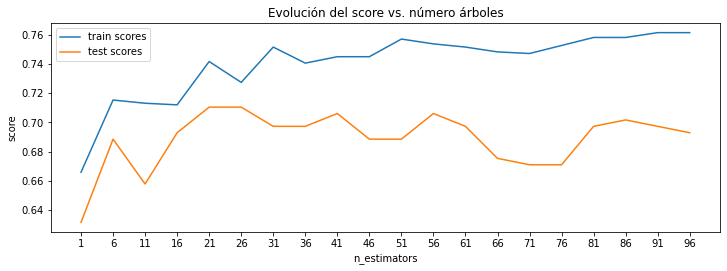

In [28]:
#Identificar cuanto es el valor de árboles (estimadores) que no me genere overfitting

train_scores = []
test_scores = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators
for n_estimators in estimator_range:
    
        modelo = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1.5, random_state=1)           
        modelo.fit(X_train, y_train)
        test_scores.append(modelo.score(X_test, y_test))
        train_scores.append(modelo.score(X_train, y_train))
    
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(12, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, test_scores, label="test scores")
ax.set_ylabel("score")
ax.set_xlabel("n_estimators")
ax.set_xticks(estimator_range)
ax.set_title("Evolución del score vs. número árboles")
plt.legend();

In [29]:
# Crear un DataFrame con las listas estimator_range y test_scores
df = pd.DataFrame({'estimator_range': estimator_range, 'train_scores': train_scores, 'test_scores': test_scores})

# Calcular la diferencia entre las dos columnas y agregarla como una nueva columna
df['diferencia'] = df['train_scores'] - df['test_scores']

# Imprimir el DataFrame resultante
print(df)

    estimator_range  train_scores  test_scores  diferencia
0                 1        0.6659       0.6316      0.0344
1                 6        0.7154       0.6886      0.0268
2                11        0.7132       0.6579      0.0553
3                16        0.7121       0.6930      0.0191
4                21        0.7418       0.7105      0.0312
5                26        0.7275       0.7105      0.0169
6                31        0.7516       0.6974      0.0543
7                36        0.7407       0.6974      0.0433
8                41        0.7451       0.7061      0.0389
9                46        0.7451       0.6886      0.0565
10               51        0.7571       0.6886      0.0685
11               56        0.7538       0.7061      0.0477
12               61        0.7516       0.6974      0.0543
13               66        0.7484       0.6754      0.0729
14               71        0.7473       0.6711      0.0762
15               76        0.7527       0.6711      0.08

In [30]:
# Obtener el primer registro del DataFrame ordenado
df.sort_values('diferencia', ascending=True).head(5)

,estimator_range,train_scores,test_scores,diferencia
5,26,0.7275,0.7105,0.0169
3,16,0.7121,0.6930,0.0191
1,6,0.7154,0.6886,0.0268
4,21,0.7418,0.7105,0.0312
0,1,0.6659,0.6316,0.0344


#### Grid Search basado en validación cruzada

### Dividir el conjunto de datos

In [28]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns ='bad_credit')
y = d['bad_credit']

# la validación cruzada se realiza sobre todo el dataset
X_Completo = X
y_Completo = y

### Escalar Variables

In [29]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'time_in_residence', 'age_yrs', 'number_loans', 'dependents']


In [30]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

X_Completo[num_vars].head()

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
0,0.1176,0.2356,0.6667,0.3333,0.1667,0.3333,0.0000
1,0.1176,0.0619,1.0000,0.6667,0.1296,0.0000,0.0000
2,0.2941,0.1487,1.0000,0.3333,0.1667,0.0000,0.0000
3,0.0735,0.0783,1.0000,0.3333,0.1111,0.0000,0.0000
4,0.3382,0.6167,0.3333,0.3333,0.1296,0.3333,0.0000


In [31]:
# Guardar el scaler
joblib.dump(scaler, './modelos/scaler/minmaxFull_GermanCredits.pkl')

['./modelos/scaler/minmaxFull_GermanCredits.pkl']

### Creación del modelo

In [32]:
#Definicion del modelo
modelAda2 = AdaBoostClassifier()


# Grid de hiperparámetros evaluados
param_grid = {'n_estimators': range(5, 51, 5),
             'learning_rate':[0.0001, 0.001,0.01,.1]
             }



# definicion de la variable con el número de pliegues
CV = 10

# las metricas sobre las se evaluará el modelo
scoring = 'f1'

# Búsqueda por grid search con validación cruzada
grid_AdaB = GridSearchCV(
                        estimator  = modelAda2,
                        param_grid = param_grid,
                        scoring    = scoring,
                        n_jobs     = - 1,
                        cv         = CV, 
                        refit      = True,
                        verbose    = 0,
                        return_train_score = True
                       )

grid_AdaB.fit(X_Completo, y_Completo)


GridSearchCV(cv=10, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'n_estimators': range(5, 51, 5)},
             return_train_score=True, scoring='f1')

In [33]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_AdaB.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
39,0.1000,50,0.7190,0.0317,0.7305,0.0078
38,0.1000,45,0.7143,0.0300,0.7261,0.0069
34,0.1000,25,0.7093,0.0263,0.7118,0.0060
26,0.0100,35,0.7062,0.0293,0.7056,0.0032
1,0.0001,10,0.7062,0.0293,0.7056,0.0032
21,0.0100,10,0.7062,0.0293,0.7056,0.0032
22,0.0100,15,0.7062,0.0293,0.7056,0.0032
23,0.0100,20,0.7062,0.0293,0.7056,0.0032
24,0.0100,25,0.7062,0.0293,0.7056,0.0032
25,0.0100,30,0.7062,0.0293,0.7056,0.0032


In [34]:
# Obtener los resultados del grid search
results_grid_AdaB = pd.DataFrame(grid_AdaB.cv_results_)

# Seleccionar las columnas deseadas
columns_grid_AdaB = ['param_learning_rate'] + \
                    ['param_n_estimators'] + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_AdaB_filtered = results_grid_AdaB[columns_grid_AdaB]

# Crear la columna scoreWithStd: f1 / std
results_grid_AdaB_filtered['scoreWithStd'] = results_grid_AdaB_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_AdaB_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_AdaB_filtered[['param_learning_rate','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']].head(10)

,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,0.0001,5,0.7062,0.0293,24.1339
1,0.0001,10,0.7062,0.0293,24.1339
2,0.0001,15,0.7062,0.0293,24.1339
3,0.0001,20,0.7062,0.0293,24.1339
4,0.0001,25,0.7062,0.0293,24.1339
5,0.0001,30,0.7062,0.0293,24.1339
6,0.0001,35,0.7062,0.0293,24.1339
7,0.0001,40,0.7062,0.0293,24.1339
8,0.0001,45,0.7062,0.0293,24.1339
9,0.0001,50,0.7062,0.0293,24.1339


In [35]:
# Top 3 de los mejores scores
results_grid_AdaB_filtered.sort_values(by='scoreWithStd', ascending=False).head(10)[
    ['param_learning_rate','param_n_estimators'
     , 'mean_test_score', 'std_test_score', 'scoreWithStd']].head(3)

,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
36,0.1000,35,0.7035,0.0242,29.1162
33,0.1000,20,0.7034,0.0246,28.6359
35,0.1000,30,0.7056,0.0253,27.9052


In [36]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_AdaB_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_learning_rate    0.1000
param_n_estimators    35.0000
mean_test_score        0.7035
std_test_score         0.0242
split0_test_score      0.7101
split1_test_score      0.7304
split2_test_score      0.7288
split3_test_score      0.7132
split4_test_score      0.6957
split5_test_score      0.6614
split6_test_score      0.7188
split7_test_score      0.6923
split8_test_score      0.6615
split9_test_score      0.7231
scoreWithStd          29.1162
Name: 36, dtype: float64

In [37]:
results_grid_AdaB_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

0.7035314137711371

In [38]:
# Usar los mejores parámetros para crear el modelo
modelAda2.set_params(learning_rate = results_grid_AdaB_filtered.loc[indice_max_scoreWithStd]['param_learning_rate']
                        , n_estimators = int(results_grid_AdaB_filtered.loc[indice_max_scoreWithStd]['param_n_estimators'])
                    )
modelAda2.fit(X_Completo, y_Completo)

AdaBoostClassifier(learning_rate=0.1, n_estimators=35)

### Guardar modelo

In [39]:
#Se guarda el modelo de Random Forest
joblib.dump(modelAda2, './modelos/clasificacion/AdaB_CV.pkl')

['./modelos/clasificacion/AdaB_CV.pkl']

#### Referencias


- Random Forest
    - https://www.cienciadedatos.net/documentos/py08_random_forest_python.html
    - https://fhernanb.github.io/libro_mod_pred/rand-forests.html
    - https://quantdare.com/decision-trees-gini-vs-entropy/
    